In [1]:
# Import manipulating files libraries
import os, glob, re

# Import plotting data libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Import loading and manipulating neuroimaging data library
import nibabel as nib

# Import array manipulating library
import numpy as np

# Import medical data augmentation libraries
import SimpleITK as sitk
from dltk.io.augmentation import *
from dltk.io.preprocessing import *

In [2]:
#Get data path
data_path = '../acerta_whole/classification/*.nii'
# Find all files within the location that matches our search string
files = glob.glob(data_path)

#Get mask path (This file is responsible for removing noise from outside brain)
mask_data = '../acerta_whole/mask_group_whole.nii'

In [10]:
data_all = []
affines = []
images = []

# Loop through files and load all data files
# We also need the information of our Nifti Files for when we save our data augmentation files to our local repository
# Because of that we will append that info into a different array to use later on
for data_file in sorted(files):
    affines.append(nib.load(data_file))
    data_all.append(nib.load(data_file).get_fdata())

# Convert our list into a numpy array
images = np.asarray(data_all)    
        
#Load mask file
mask_file = nib.load(mask_data).get_fdata()

#Verify if the whole brain mask is boolean
mask_file = mask_file.astype(bool)

In [11]:
# Create list to append our masked files before augmentation
masked_files = []

# Loop through our files, doing a matrix multiplication to remove noise outside of the brain
# Our mask file is a boolean file thus:
# Any number multiplied for 0 is removed (becomes zero) 
# And any number multiplied for 1 remains unchanged 
for f in images:
    masked_files.append(np.array(f * mask_file))

# Here, we loop through our masked files to convert them to Nifti Files to save to our local repository
# We need the affine information of our files so we can maintain the same properties when saving our new masked files
# to our local repository
convert_masked_files = []
for (f, aff) in zip(masked_files, affines):
    convert_masked_files.append(nib.Nifti1Image(f, affine=aff.affine))

# We loop through our data to get the exact name of all files
# The reason we do this is to save the files with the same name to our local repository
without_nii = []
for f in sorted(files):
    fname = re.findall('\w+\.', f)
    subj = fname[0]
    without_nii.append(subj[:-1])

# We loop through our masked files and the file names we successfuly acquired, saving to our local repository
# The reason we do this is so we won't have to mask our files again if we need to use them
for (masked, x) in zip(convert_masked_files, without_nii):
    fname_m = os.path.join('../acerta_whole/masked_files/', '{0}_{1}.nii.gz'.format(x, 'masked'))
    nib.save(masked, fname_m)

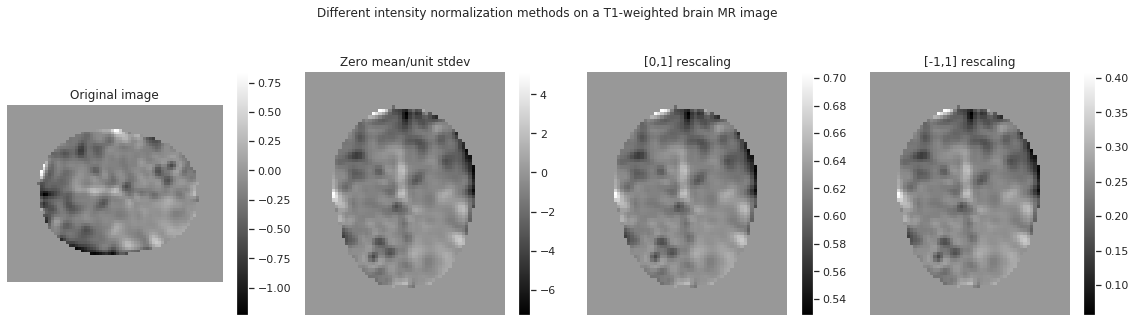

In [20]:
# Now, we will manipulate our masked files
# We will normalize our data and perform data augmentation
# First, we load our masked files (files that had the noise outside brain removed)
datapath_masked = '../acerta_whole/masked_files/*.nii.gz'
files_masked = glob.glob(datapath_masked)


# We loop through our data and load with the SITK library to perform data augmentation
# After that, we convert our image files to numpy arrays
images_sitk = []
imgs_converted = []
for x in sorted(files_masked):
    img_sitk = sitk.ReadImage(x)
    images_sitk.append(img_sitk)
    imgs_converted.append(sitk.GetArrayFromImage(img_sitk))

# Here, we normalize the image to zero mean/unit std dev using volume statistics: 
# The library contains other two options of normalization, but we adopt the standard one in our work
# However, we plot all options that the library offers

# Zero mean/unit std dev, which is called whitening in the library
t1_white = []
# Normalise the image to fit [0, 1] range:
t1_norm_zo = []
# Normalise the image to fit [-1, 1] range:
t1_norm_oo = []
for img in imgs_converted:
    t1_white.append(whitening(img))
    t1_norm_zo.append(normalise_zero_one(img))
    t1_norm_oo.append(normalise_one_one(img))
    
# Plot our data using matplotlib from a central slice of the brain
center_slices = [s//2 for s in imgs_converted[0].shape]

# We transpose the axis 0 so we can have the axial view when plotting
img_rol = imgs_converted[0].transpose(2,1,0)

f, ax = plt.subplots(1, 4, figsize=(20,5));
f.suptitle('Different intensity normalization methods on a T1-weighted brain MR image')

img = ax[0].imshow(np.squeeze(img_rol[:, :, center_slices[0]]), cmap='gray');
ax[0].axis('off')
ax[0].set_title('Original image')
f.colorbar(img, ax=ax[0])

img = ax[1].imshow(np.squeeze(t1_white[0][center_slices[0], :, :]), cmap='gray');
ax[1].axis('off')
ax[1].set_title('Zero mean/unit stdev')
f.colorbar(img, ax=ax[1])

img = ax[2].imshow(np.squeeze(t1_norm_zo[0][center_slices[0], :, :]), cmap='gray');
ax[2].axis('off')
ax[2].set_title('[0,1] rescaling')
f.colorbar(img, ax=ax[2])

img = ax[3].imshow(np.squeeze(t1_norm_oo[0][center_slices[0], :, :]), cmap='gray');
ax[3].axis('off')
ax[3].set_title('[-1,1] rescaling')
f.colorbar(img, ax=ax[3])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();

In [24]:
# Data augmentation

# Below we apply different augmentation techniques, which are commonly used for enriching the training dataset 
# and training more robust models. These are applied to the whitened normalized image computed above.

# For demo purposes, we extract a 2D slice from the image volume. This is just to better demonstrate the Gaussian 
# offset augmentation. To demonstrate, that this works on volumes, we ensure that the slice is a 3D volume: 
center_slices = [s//2 for s in imgs_converted[0].shape]
t1_slice = imgs_a[0][center_slices[0]:center_slices[0]+1,:,:].copy()

# Add a feature dimension and normalize
t1_norm = np.expand_dims(normalise_one_one(t1_slice), axis=-1)

# Randomly flip the image along axis 1
t1_flipped = flip(t1_norm.copy(), axis=1)

# Add a Gaussian offset (independently for each channel)
t1_offset = add_gaussian_offset(t1_norm.copy(), sigma=0.5)

# Add Gaussian noise
t1_noise = add_gaussian_noise(t1_norm.copy(), sigma=0.15)

# Elastic transforms according to:
# [1] Simard, Steinkraus and Platt, "Best Practices for Convolutional
#     Neural Networks applied to Visual Document Analysis", in Proc. of the
#     International Conference on Document Analysis and Recognition, 2003.
t1_trans_low_s = elastic_transform(t1_norm.copy(), alpha=[1, 1e5, 1e5], sigma=[1, 12, 12])
t1_trans_high_s = elastic_transform(t1_norm.copy(), alpha=[10, 2e6, 2e6], sigma=[1, 25, 25])

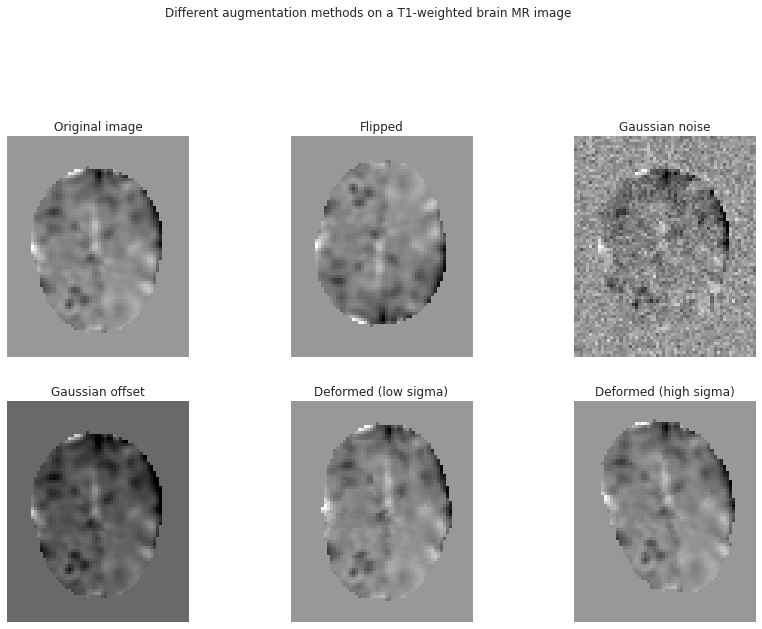

In [23]:
# Plotting the different types of data augmentation using matplotlib
f, ax = plt.subplots(2, 3, figsize=(15,10));
f.suptitle('Different augmentation methods on a T1-weighted brain MR image')

ax[0,0].imshow(np.squeeze(t1_norm), cmap='gray', vmin=-1, vmax=1);
ax[0,0].axis('off')
ax[0,0].set_title('Original image')

ax[0,1].imshow(np.squeeze(t1_flipped), cmap='gray', vmin=-1, vmax=1);
ax[0,1].axis('off')
ax[0,1].set_title('Flipped')

ax[0,2].imshow(np.squeeze(t1_noise), cmap='gray', vmin=-1, vmax=1);
ax[0,2].axis('off')
ax[0,2].set_title('Gaussian noise')

ax[1,0].imshow(np.squeeze(t1_offset), cmap='gray', vmin=-1, vmax=1);
ax[1,0].axis('off')
ax[1,0].set_title('Gaussian offset')

ax[1,1].imshow(np.squeeze(t1_trans_low_s), cmap='gray', vmin=-1, vmax=1);
ax[1,1].axis('off')
ax[1,1].set_title('Deformed (low sigma)')

ax[1,2].imshow(np.squeeze(t1_trans_high_s), cmap='gray', vmin=-1, vmax=1);
ax[1,2].axis('off')
ax[1,2].set_title('Deformed (high sigma)')
    
f.subplots_adjust(wspace=0.05, top=0.8)
plt.show();

In [ ]:
# We showed all data augmentation techniques that the library offers. However, in our work we only adopt
# Gaussian noise and Gaussian offset.

# Files masked
data_path = '../acerta_whole/masked_files/*.nii.gz'
files = glob.glob(data_path)

#Read data with sitk
images = []
imgs = []
without_nii = []
img_aff = []
for f in sorted(files):
    #print(f)
    fname = re.findall('\w+\_', f)
    #print(fname)
    subj = fname[1]
    #print(subj[:-1])
    without_nii.append(subj[:-1])
    images.append(sitk.ReadImage(f))
    img_aff.append(nib.load(f))
    
for img in images:
    imgs.append(sitk.GetArrayFromImage(img))

# Normalise the image to zero mean/unit std dev using volume statistics:
t1_white = []
# Normalise the image to fit [0, 1] range:
t1_norm_zo = []
# Normalise the image to fit [-1, 1] range:
t1_norm_oo = []
for img in imgs:
    t1_white.append(whitening(img))
    t1_norm_zo.append(normalise_zero_one(img))
    t1_norm_oo.append(normalise_one_one(img))
    
imgs_rol = []

for img in t1_white:
    imgs_rol.append(img.transpose(2,1,0))

converted_imgs = []
data_affine = np.asarray(img_aff)
for (img, aff) in zip(imgs_rol, img_aff):
    converted_imgs.append(nib.Nifti1Image(img, affine=aff.affine))
    
for (img, x) in zip(converted_imgs, without_nii):
    fname = os.path.join('/media/gpin/datasets/AMBAC/cutoff/white_aligned/', '{0}_{1}.nii.gz'.format(x, 'white'))
    nib.save(img, fname)
#    print(fname)
    #sitk.WriteImage(img, fname)

In [ ]:
# Data augmentation

# Below we apply different augmentation techniques, which are commonly used for enriching the training dataset 
# and training more robust models. These are applied to the whitened normalised image computed above.

# For demo purposes, extract a 2D slice from the image volume. This is just to better
# demonstrate the Gaussian offset augmentation. To demonstrate, that this works on 
# volumes, we ensure that the slice is a 3D volume: 
center_slices = [s//2 for s in imgs_a[0].shape]
t1_slice = imgs_a[0][center_slices[0]:center_slices[0]+1,:,:].copy()
print(t1_slice.shape)

# Add a feature dimension and normalise
t1_norm = np.expand_dims(normalise_one_one(t1_slice), axis=-1)
print(t1_norm.shape)

# Add a Gaussian offset (independently for each channel)
t1_offset = add_gaussian_offset(t1_norm.copy(), sigma=0.5)
print(t1_offset.shape)

# Add Gaussian noise
t1_noise = add_gaussian_noise(t1_norm.copy(), sigma=0.15)

# Add a feature dimension and normalise
t1_norm = []
# Add a Gaussian offset (independently for each channel)
t1_offset = []
# Add a Gaussian offset (independently for each channel)
t1_noise = []
for img in imgs:
    t1_norm.append(np.expand_dims(normalise_one_one(img), axis=-1))

for img in t1_norm:
    t1_offset.append(add_gaussian_offset(img.copy(), sigma=0.5))
    t1_noise.append(add_gaussian_noise(img.copy(), sigma=0.15))

off_sq, noise_sq = [], []
for (off, noi) in zip(t1_offset, t1_noise):
    off_sq.append(np.squeeze(off))
    #print(off.shape, np.squeeze(off).shape)
    noise_sq.append(np.squeeze(noi))
    
imgs_off_rol = []
imgs_noi_rol = []
for (off, noi) in zip(off_sq, noise_sq):
    imgs_off_rol.append(off.transpose(2,1,0))
    imgs_noi_rol.append(noi.transpose(2,1,0))
    
# Convert numpy array to Nifti
converted_images_off = []
converted_images_noi = []
for (off, noi, aff) in zip(imgs_off_rol, imgs_noi_rol, data_affine):
    converted_images_off.append(nib.Nifti1Image(off, affine=aff.affine))
    converted_images_noi.append(nib.Nifti1Image(noi, affine=aff.affine))
    
#print(len(converted_images_off), len(converted_images_noi))

for (off, noi, x) in zip(converted_images_off, converted_images_noi, without_nii):
    fname_off = os.path.join('/media/gpin/datasets/AMBAC/cutoff/offset_aligned/', '{0}_{1}.nii.gz'.format(x, 'offset'))
    fname_noi = os.path.join('/media/gpin/datasets/AMBAC/cutoff/noise_aligned/', '{0}_{1}.nii.gz'.format(x, 'noise'))
    nib.save(off, fname_off)
    nib.save(noi, fname_noi)
    #print(fname)
    #sitk.WriteImage(img, fname)